In [1]:
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, iirnotch
import numpy as np
import os

def bandpass_filter(data, lowcut=20.0, highcut=500.0, fs=2000.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, notch_freq=50.0, fs=2000.0, Q=30.0):
    b, a = iirnotch(notch_freq, Q, fs)
    return filtfilt(b, a, data, axis=0)

mat_dir = './raw_data/ninapro_db1'
mat_files = [f for f in os.listdir(mat_dir) if f.endswith('.mat')]

save_root = './preprocessed_emg_by_label'
os.makedirs(save_root, exist_ok=True)

for mat_file in mat_files:
    print(f'Processing {mat_file}...')
    mat_path = os.path.join(mat_dir, mat_file)
    mat_data = loadmat(mat_path)

    emg = mat_data['emg']
    restimulus = mat_data['restimulus'].flatten()
    rerepetition = mat_data['rerepetition'].flatten()

    fs = 2000
    emg_filtered = notch_filter(emg, notch_freq=50.0, fs=fs)
    emg_filtered = bandpass_filter(emg_filtered, lowcut=20.0, highcut=500.0, fs=fs)
    emg_filtered = np.abs(emg_filtered)
    
    subject_name = mat_file.replace('.mat', '')
    save_dir = os.path.join(save_root, subject_name)
    os.makedirs(save_dir, exist_ok=True)

    unique_labels = np.unique(restimulus)
    unique_labels = unique_labels[unique_labels != 0]

    for label in unique_labels:
        label_dir = os.path.join(save_dir, f'label_{int(label)}')
        os.makedirs(label_dir, exist_ok=True)
        label_idx = np.where(restimulus == label)[0]
        label_reps = rerepetition[label_idx]
        emg_label = emg_filtered[label_idx, :]
        unique_reps = np.unique(label_reps)
        for rep in unique_reps:
            rep_idx = np.where(label_reps == rep)[0]
            emg_rep = emg_label[rep_idx, :]
            np.savetxt(os.path.join(label_dir, f'rep_{int(rep)}.csv'), emg_rep, delimiter=",")

print("Preprocessing done.")


Processing S10_A1_E1.mat...
Processing S11_A1_E1.mat...
Processing S12_A1_E1.mat...
Processing S13_A1_E1.mat...
Processing S14_A1_E1.mat...
Processing S15_A1_E1.mat...
Processing S16_A1_E1.mat...
Processing S17_A1_E1.mat...
Processing S18_A1_E1.mat...
Processing S19_A1_E1.mat...
Processing S1_A1_E1.mat...
Processing S20_A1_E1.mat...
Processing S21_A1_E1.mat...
Processing S22_A1_E1.mat...
Processing S23_A1_E1.mat...
Processing S24_A1_E1.mat...
Processing S25_A1_E1.mat...
Processing S26_A1_E1.mat...
Processing S27_A1_E1.mat...
Processing S2_A1_E1.mat...
Processing S3_A1_E1.mat...
Processing S4_A1_E1.mat...
Processing S5_A1_E1.mat...
Processing S6_A1_E1.mat...
Processing S7_A1_E1.mat...
Processing S8_A1_E1.mat...
Processing S9_A1_E1.mat...
Preprocessing done.


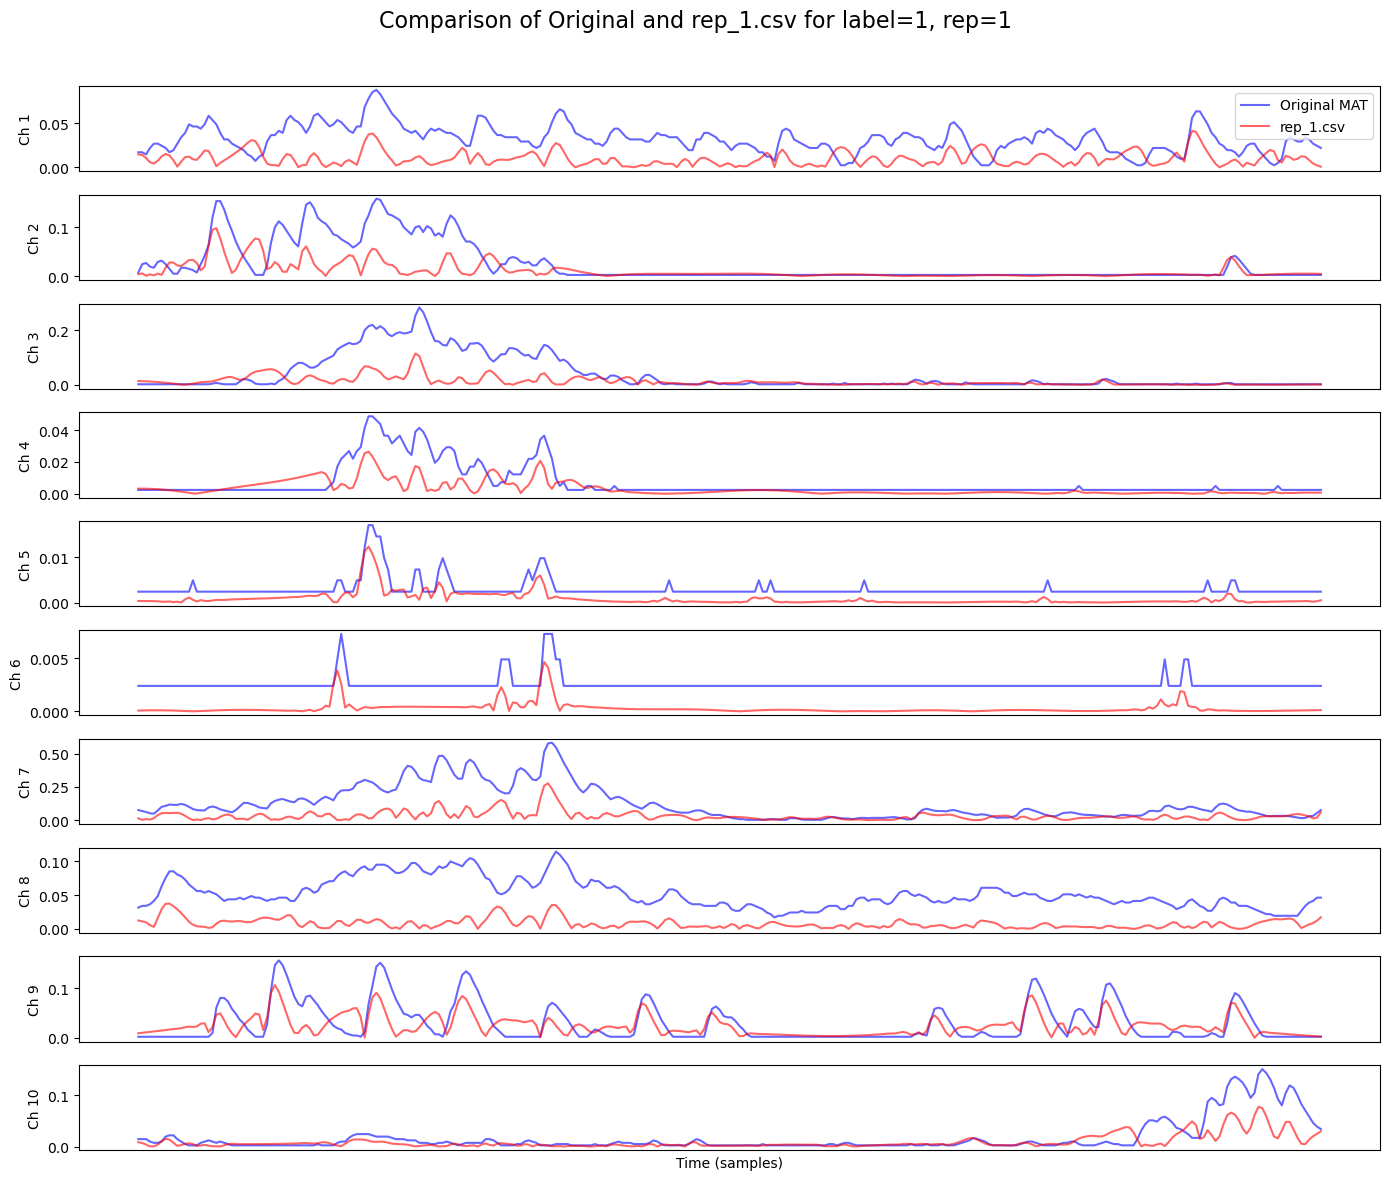

In [3]:
### Compare preprocessing data and original data ###
import pandas as pd
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

rep1_df = pd.read_csv("./preprocessed_emg_by_label/S1_A1_E1/label_1/rep_1.csv")
mat_data = scipy.io.loadmat("./raw_data/ninapro_db1/S1_A1_E1.mat")

emg = mat_data['emg']
restimulus = mat_data['restimulus'].flatten()
rerepetition = mat_data['rerepetition'].flatten()

mask = (restimulus == 1) & (rerepetition == 1)
emg_filtered = emg[mask]

min_len = min(len(rep1_df), len(emg_filtered))
rep1_array = rep1_df.iloc[:min_len, :10].values 
emg_filtered = emg_filtered[:min_len]

time = np.arange(min_len)

plt.figure(figsize=(14, 12))
for i in range(10):
    plt.subplot(10, 1, i + 1)
    plt.plot(time, emg_filtered[:, i], label='Original MAT', color='blue', alpha=0.6)
    plt.plot(time, rep1_array[:, i], label='rep_1.csv', color='red', alpha=0.6)
    plt.ylabel(f'Ch {i+1}')
    if i == 0:
        plt.legend(loc='upper right')
    plt.xticks([])

plt.suptitle('Comparison of Original and rep_1.csv for label=1, rep=1', fontsize=16)
plt.xlabel('Time (samples)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
